# Data Understanding

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import random
from matplotlib import patches as mpatches

base_dir = Path("../data/cmp_facade_dataset")
image_dir = base_dir / "images"
annotation_dir = base_dir / "annotations"


In [2]:
def count_files_by_split(path):
    return {split.name: len(list(split.glob("*.png"))) for split in path.iterdir() if split.is_dir()}

print("Images:")
print(count_files_by_split(image_dir))
print("Annotations:")
print(count_files_by_split(annotation_dir))


Images:
{'eval': 114, 'test': 114, 'train': 378}
Annotations:
{'eval': 114, 'test': 114, 'train': 378}


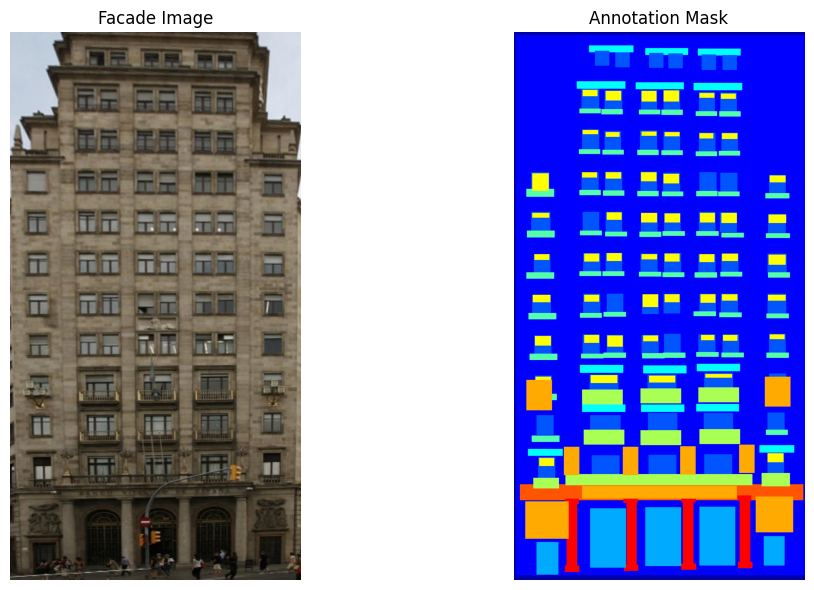

In [3]:
def show_image_and_mask(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title("Facade Image")
    axs[0].axis('off')

    axs[1].imshow(mask)
    axs[1].set_title("Annotation Mask")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

# Sample image
train_image_path = image_dir / "train" / "image_0.png"
train_mask_path = annotation_dir / "train" / "annotation_0.png"

show_image_and_mask(train_image_path, train_mask_path)


In [4]:
def unique_classes_in_mask(mask_path):
    mask = np.array(Image.open(mask_path))
    unique_classes = np.unique(mask)
    return unique_classes

classes = unique_classes_in_mask(train_mask_path)
print("Unique classes in mask:", classes)


Unique classes in mask: [ 1  2  3  4  5  6  7  8  9 10 11]


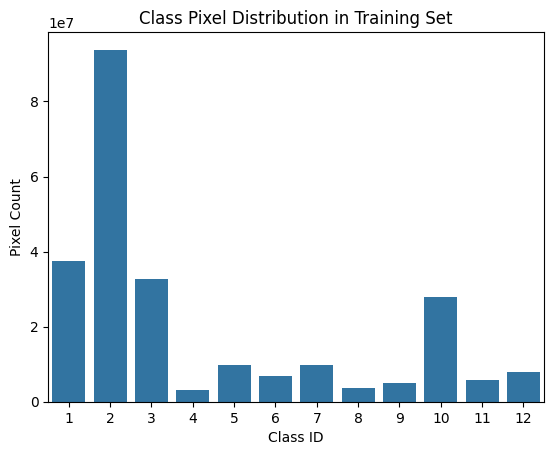

In [5]:
from collections import Counter

def compute_class_distribution(annotation_paths):
    class_counts = Counter()
    for path in annotation_paths:
        mask = np.array(Image.open(path))
        class_ids, counts = np.unique(mask, return_counts=True)
        class_counts.update(dict(zip(class_ids, counts)))
    return class_counts

train_anns = list((annotation_dir / "train").glob("*.png"))
dist = compute_class_distribution(train_anns)

# Plot
sns.barplot(x=list(dist.keys()), y=list(dist.values()))
plt.title("Class Pixel Distribution in Training Set")
plt.xlabel("Class ID")
plt.ylabel("Pixel Count")
plt.show()


# Validating the Annotation sets
As we saw, we have classes ranging from 1 to 12. I want to check if all images contain only these classes and the amount of 12 unique classes, for ideal training we would need a consistent set with consistent classes. </br>
I also want to check the average class balance on each set to know with what balance we are working with.

In [6]:
def get_unique_classes_by_split(annotation_dir):
    unique_classes_per_split = {}

    for split in ["train", "eval", "test"]:
        paths = list((annotation_dir / split).glob("*.png"))
        all_classes = set()
        for path in paths:
            mask = np.array(Image.open(path))
            all_classes.update(np.unique(mask))
        unique_classes_per_split[split] = sorted(all_classes)

    return unique_classes_per_split

unique_classes = get_unique_classes_by_split(annotation_dir)
print("\n Unique Classes in Each Split:")
for split, classes in unique_classes.items():
    print(f" - {split}: {classes}")



 Unique Classes in Each Split:
 - train: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
 - eval: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
 - test: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


We have 12 unique classes in this data set which is correct

In [7]:
# valid class IDs: 1–12
VALID_CLASSES = set(range(1, 13))

def find_invalid_class_masks_with_counts(annotation_root):
    invalid_files = {}
    invalid_class_counts = Counter()
    invalid_counts_per_split = {}

    for split_dir in annotation_root.iterdir():
        if split_dir.is_dir():
            invalids = []
            for mask_path in split_dir.glob("*.png"):
                mask = np.array(Image.open(mask_path))
                unique_classes = np.unique(mask)
                invalid = [cls for cls in unique_classes if cls not in VALID_CLASSES]
                if invalid:
                    invalids.append((mask_path.name, invalid))
                    invalid_class_counts.update(invalid)
            if invalids:
                invalid_files[split_dir.name] = invalids
                invalid_counts_per_split[split_dir.name] = len(invalids)
    
    return invalid_files, invalid_class_counts, invalid_counts_per_split

# Run the check
invalid_class_masks, invalid_class_counts, invalid_counts_per_split = find_invalid_class_masks_with_counts(annotation_dir)

# Print results
if invalid_class_masks:
    for split, files in invalid_class_masks.items():
        print(f"\n Invalid Class IDs in '{split}':")
        for fname, invalid_ids in files:
            print(f" - {fname}: {invalid_ids}")

    print("\n Total Invalid Class Counts:")
    for cls, count in invalid_class_counts.items():
        print(f"Class {cls}: {count} occurrences")

    print("\n Invalid Masks Per Split:")
    for split, count in invalid_counts_per_split.items():
        print(f"Split '{split}': {count} invalid masks")
else:
    print("All masks contain only valid class IDs (1–12).")


All masks contain only valid class IDs (1–12).


# Check class balance:

C:\Users\alpay\AppData\Local\Temp\ipykernel_10284\3175528216.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_ids, y=avg_pixels, palette="viridis")


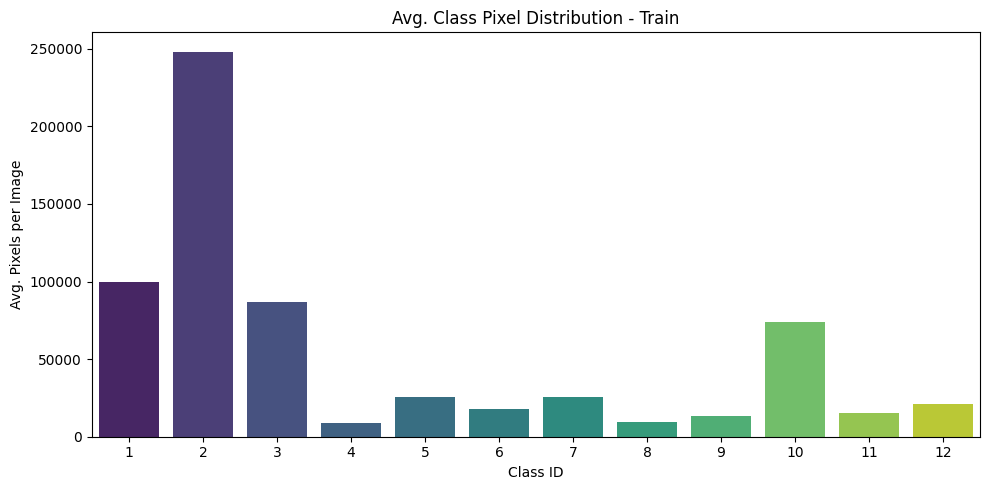

C:\Users\alpay\AppData\Local\Temp\ipykernel_10284\3175528216.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_ids, y=avg_pixels, palette="viridis")


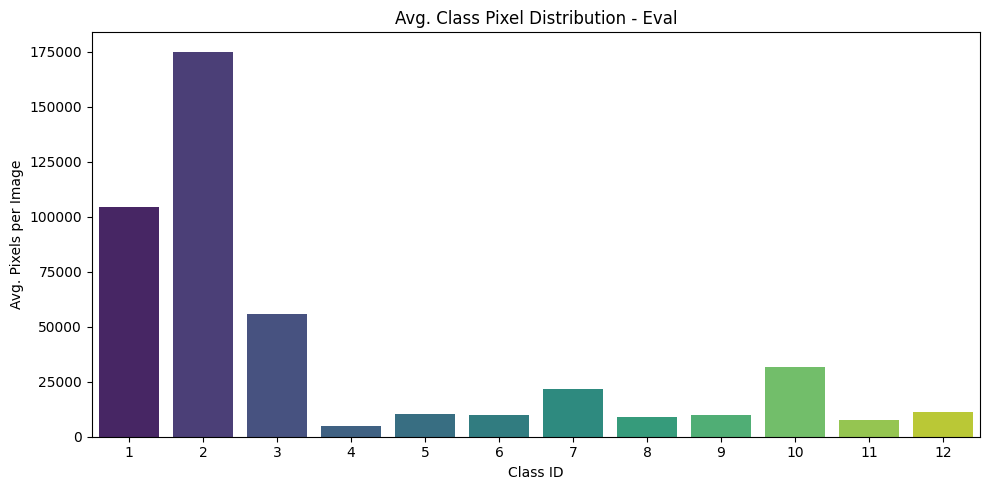

C:\Users\alpay\AppData\Local\Temp\ipykernel_10284\3175528216.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_ids, y=avg_pixels, palette="viridis")


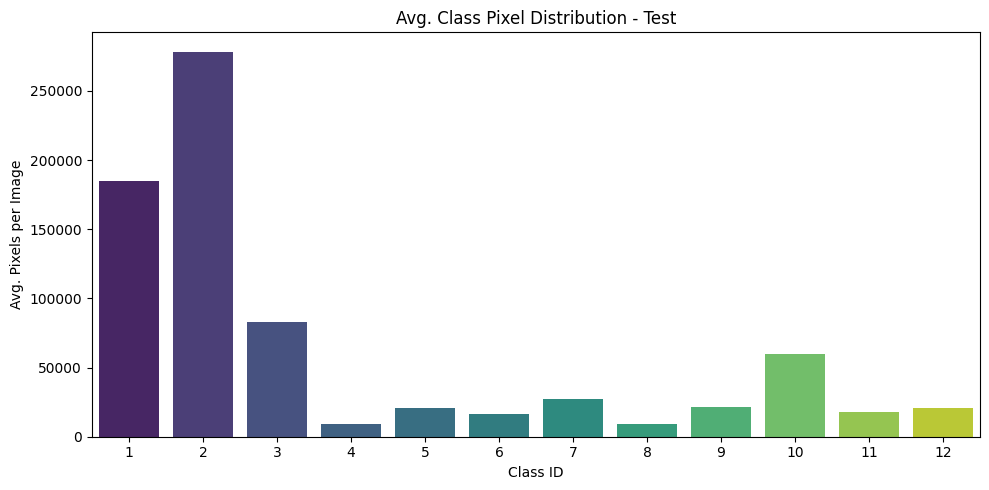

In [8]:
def compute_average_class_distribution(annotation_paths):
    class_sums = Counter()
    total_images = len(annotation_paths)

    for path in annotation_paths:
        mask = np.array(Image.open(path))
        class_ids, counts = np.unique(mask, return_counts=True)
        class_sums.update(dict(zip(class_ids, counts)))

    avg_distribution = {cls: class_sums[cls] / total_images for cls in class_sums}
    return avg_distribution

def plot_class_distribution_by_split(annotation_dir):
    for split in ["train", "eval", "test"]:
        paths = list((annotation_dir / split).glob("*.png"))
        avg_dist = compute_average_class_distribution(paths)

        # Prepare data for plotting
        class_ids = sorted(avg_dist.keys())
        avg_pixels = [avg_dist[cls] for cls in class_ids]

        # Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x=class_ids, y=avg_pixels, palette="viridis")
        plt.title(f"Avg. Class Pixel Distribution - {split.capitalize()}")
        plt.xlabel("Class ID")
        plt.ylabel("Avg. Pixels per Image")
        plt.xticks()
        plt.tight_layout()
        plt.show()

plot_class_distribution_by_split(annotation_dir)


Very satisfied with class balance, look well distributed. So we do not have to worry about a class imbalance currently.

# Look at images with different color mapping
I do this so I can see all the different classes more clear because the original segments are RGB values from 1 to 12 which doesn't show very clear differences

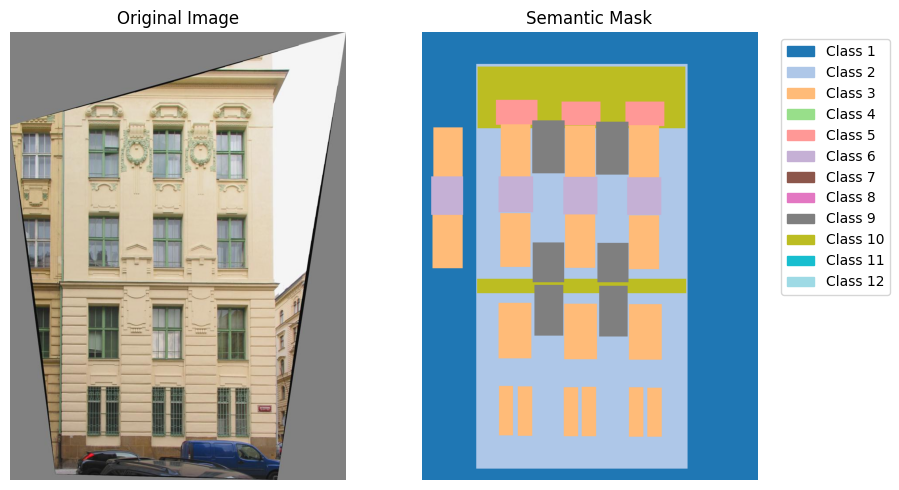

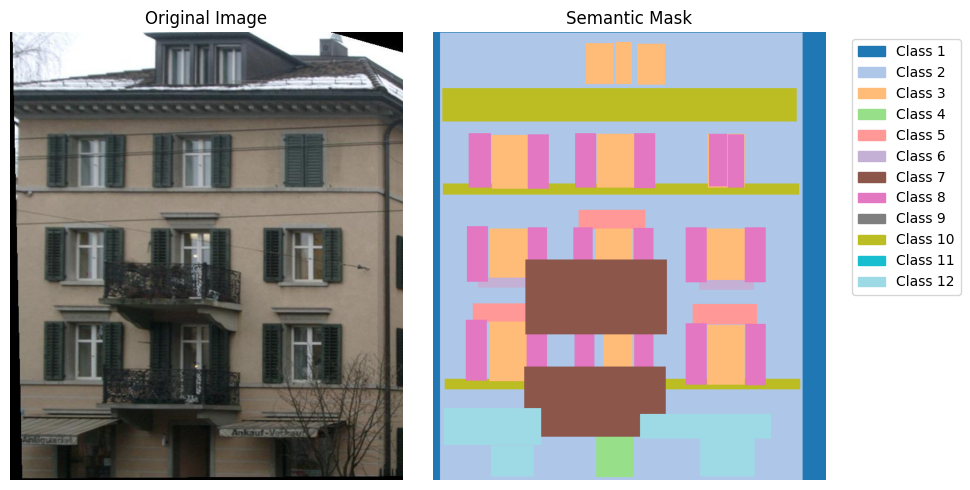

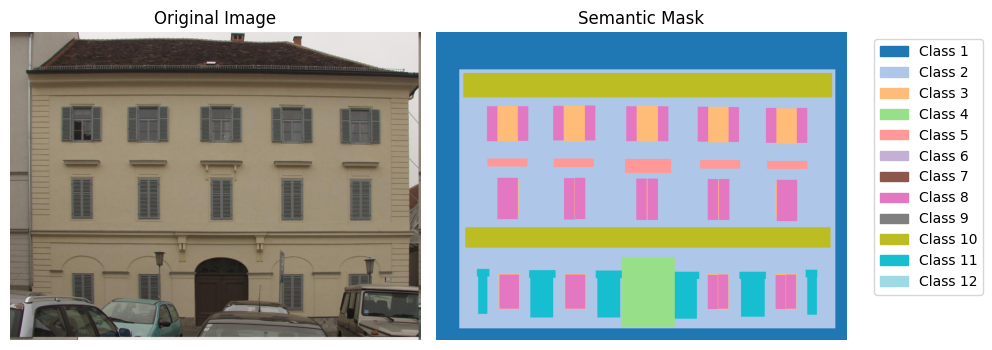

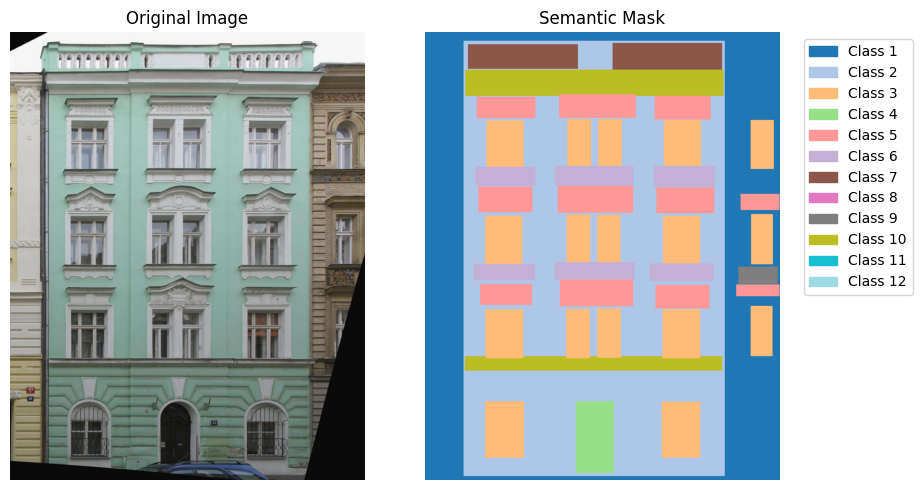

In [9]:
# Assign fixed colors to each class
COLORS = plt.cm.tab20(np.linspace(0, 1, len(VALID_CLASSES)))

def visualize_masks_with_legend(annotation_dir, image_dir, split="train", num_samples=4):
    ann_paths = list((annotation_dir / split).glob("*.png"))
    sampled = random.sample(ann_paths, num_samples)

    for ann_path in sampled:
        # Load mask and image
        mask = np.array(Image.open(ann_path))
        img_id = ann_path.name.replace("annotation", "image")
        img_path = image_dir / split / img_id
        image = Image.open(img_path)

        # Create color-coded RGB mask
        mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for class_id, color in zip(sorted(VALID_CLASSES), COLORS * 255):
            mask_rgb[mask == class_id] = color[:3]

        # Plot side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        axs[1].imshow(mask_rgb)
        axs[1].set_title("Semantic Mask")
        axs[1].axis("off")

        # Add legend
        patches = [mpatches.Patch(color=np.array(color[:3]) / 255, label=f"Class {class_id}")
                   for class_id, color in zip(sorted(VALID_CLASSES), COLORS * 255)]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Run the visualizer
visualize_masks_with_legend(annotation_dir, image_dir, split="train", num_samples=4)


# Look at original segment image annotations with class list (RGB values)

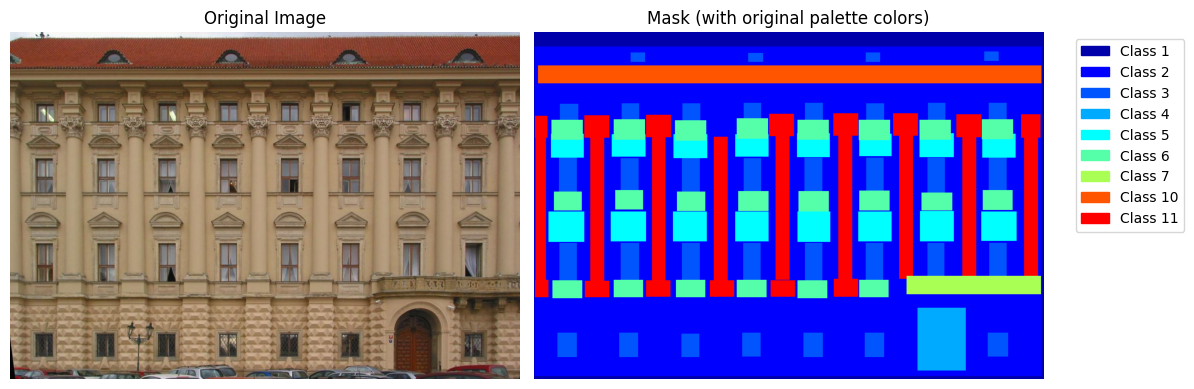

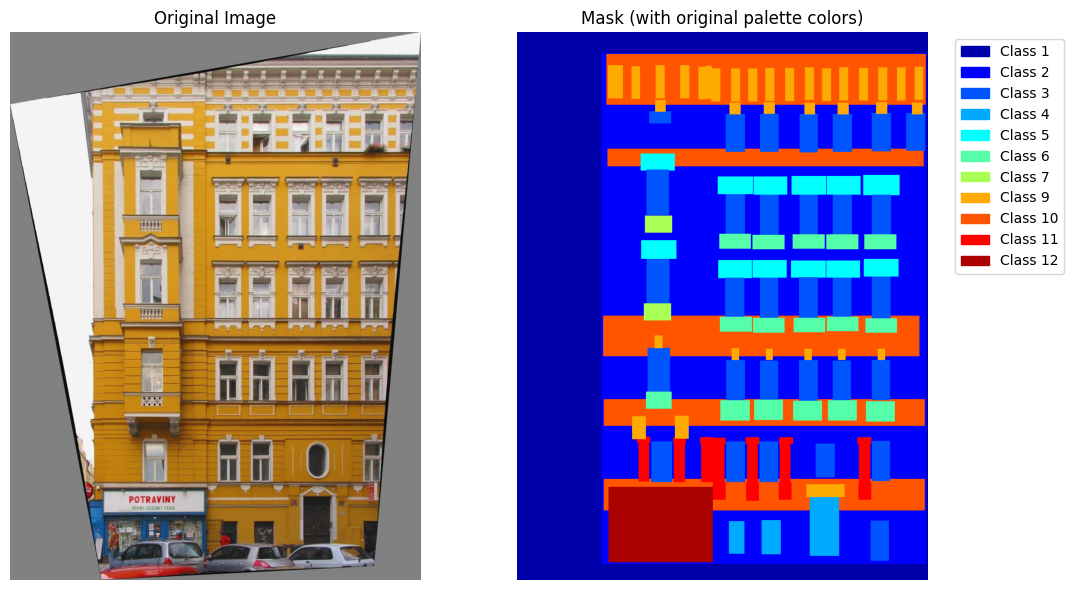

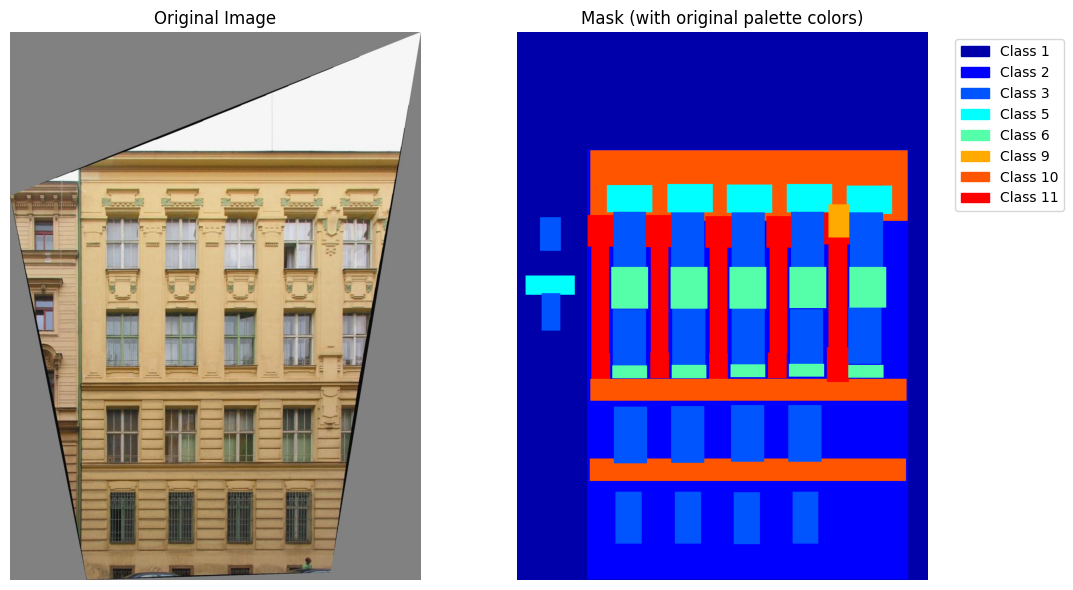

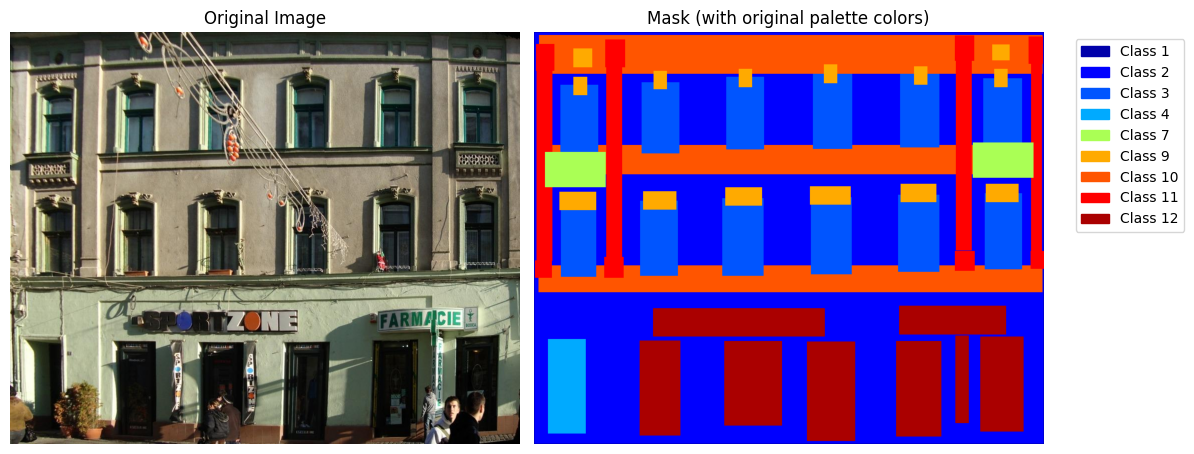

In [10]:

def get_palette_from_mask(mask_path):
    with Image.open(mask_path) as img:
        palette = img.getpalette()
        palette = np.array(palette).reshape(-1, 3)
        return palette

def visualize_real_palette_masks(annotation_dir, image_dir, split="train", num_samples=4):
    ann_paths = list((annotation_dir / split).glob("*.png"))
    sampled = random.sample(ann_paths, num_samples)

    for ann_path in sampled:
        mask = Image.open(ann_path)
        palette = get_palette_from_mask(ann_path)
        mask_np = np.array(mask)

        img_id = ann_path.name.replace("annotation", "image")
        img_path = image_dir / split / img_id
        image = Image.open(img_path)

        # Map each unique class ID to its RGB color
        unique_ids = np.unique(mask_np)
        color_map = {cls: tuple(palette[cls]) for cls in unique_ids}

        # Convert mask to RGB using its palette
        mask_rgb = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
        for cls, color in color_map.items():
            mask_rgb[mask_np == cls] = color

        # Plot image and decoded mask
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(image)
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        axs[1].imshow(mask_rgb)
        axs[1].set_title("Mask (with original palette colors)")
        axs[1].axis("off")

        # Create legend from colors
        patches = [mpatches.Patch(color=np.array(color)/255, label=f"Class {cls}")
                   for cls, color in color_map.items()]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Use your paths
visualize_real_palette_masks(annotation_dir, image_dir, split="train", num_samples=4)



# Extract coordinates from segments, construct new segments from the coordinates
In case we are training on specific models that explecitly require coordinate type annotation, we will be testing and validating if we can correctly extract the coordinates from the png annotations

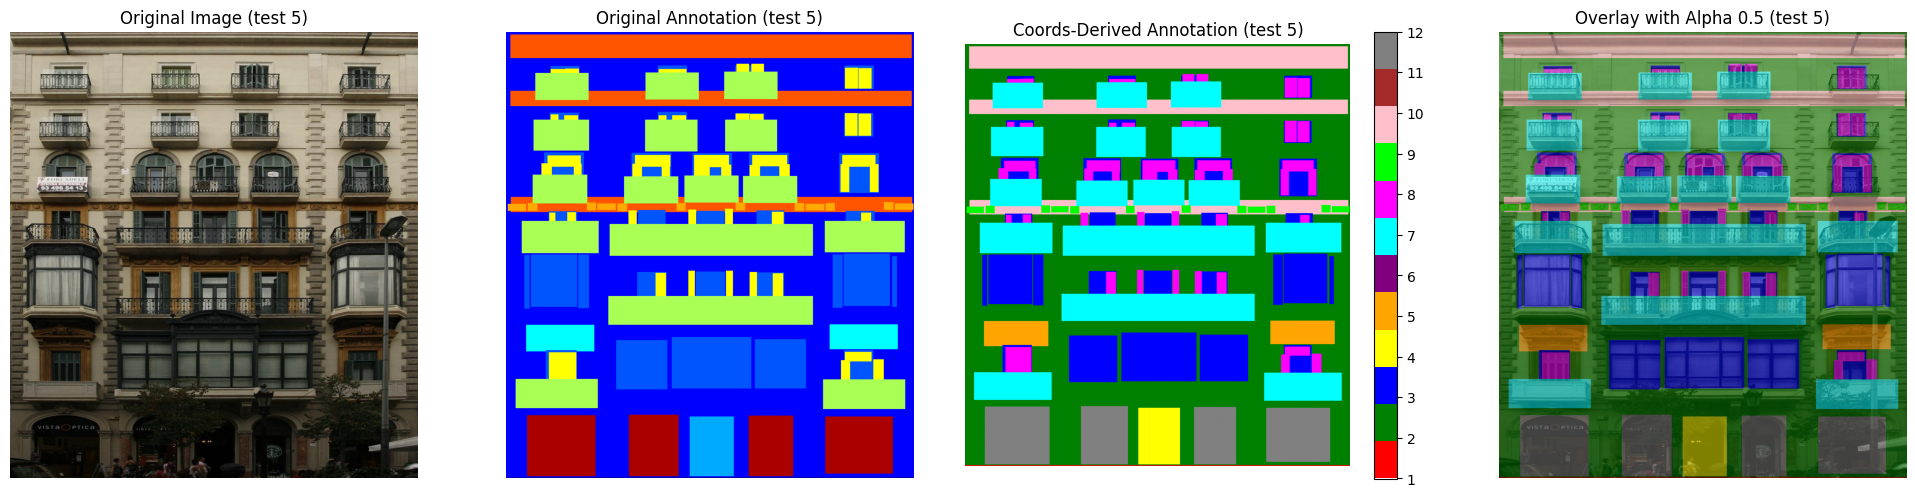

Coordinates for test image 5:
Class 1: 3732 pixels, sample: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)]
Class 2: 393809 pixels, sample: [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
Class 3: 115111 pixels, sample: [(347, 79), (348, 79), (349, 79), (350, 79), (351, 79)]
Class 4: 13837 pixels, sample: [(420, 883), (421, 883), (422, 883), (423, 883), (424, 883)]
Class 5: 18195 pixels, sample: [(740, 672), (741, 672), (742, 672), (743, 672), (744, 672)]
Class 7: 196983 pixels, sample: [(499, 93), (500, 93), (501, 93), (502, 93), (503, 93)]
Class 8: 43001 pixels, sample: [(527, 75), (528, 75), (529, 75), (530, 75), (531, 75)]
Class 9: 5706 pixels, sample: [(864, 392), (865, 392), (866, 392), (867, 392), (868, 392)]
Class 10: 92481 pixels, sample: [(10, 8), (11, 8), (12, 8), (13, 8), (14, 8)]
Class 12: 72537 pixels, sample: [(281, 879), (282, 879), (283, 879), (284, 879), (285, 879)]


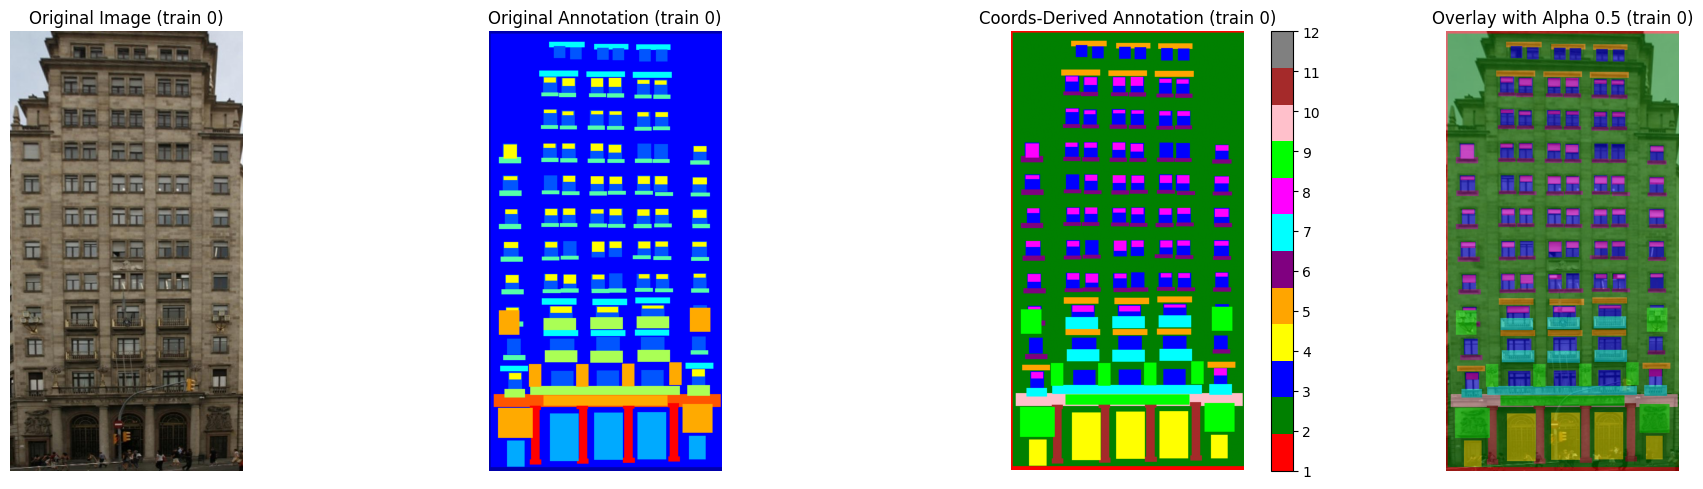

Coordinates for train image 0:
Class 1: 12181 pixels, sample: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)]
Class 2: 328822 pixels, sample: [(4, 6), (5, 6), (6, 6), (7, 6), (8, 6)]
Class 3: 60264 pixels, sample: [(151, 35), (152, 35), (153, 35), (154, 35), (155, 35)]
Class 4: 26823 pixels, sample: [(346, 887), (347, 887), (348, 887), (349, 887), (350, 887)]
Class 5: 15233 pixels, sample: [(140, 25), (141, 25), (142, 25), (143, 25), (144, 25)]
Class 6: 21635 pixels, sample: [(122, 143), (123, 143), (124, 143), (125, 143), (126, 143)]
Class 7: 22243 pixels, sample: [(344, 664), (345, 664), (346, 664), (347, 664), (348, 664)]
Class 8: 22328 pixels, sample: [(128, 108), (129, 108), (130, 108), (131, 108), (132, 108)]
Class 9: 28868 pixels, sample: [(468, 644), (469, 644), (470, 644), (471, 644), (472, 644)]
Class 10: 6676 pixels, sample: [(11, 845), (12, 845), (13, 845), (14, 845), (15, 845)]
Class 11: 10959 pixels, sample: [(417, 866), (418, 866), (419, 866), (420, 866), (421, 866)]


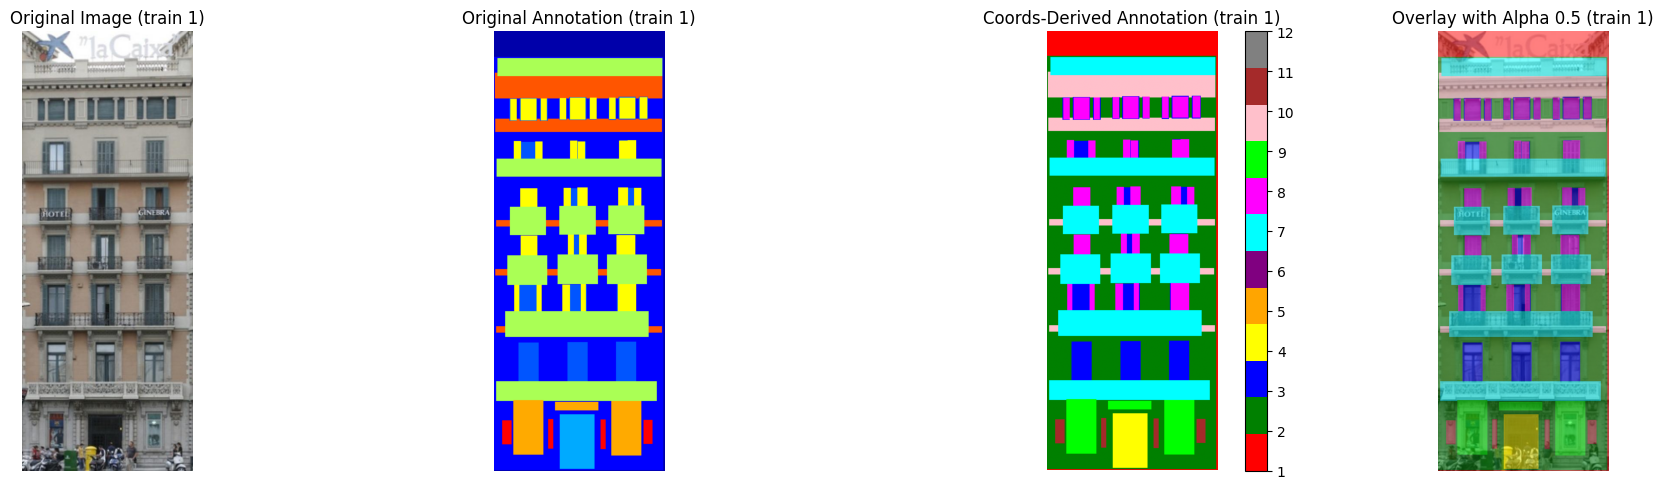

Coordinates for train image 1:
Class 1: 28524 pixels, sample: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)]
Class 2: 150788 pixels, sample: [(0, 60), (1, 60), (2, 60), (3, 60), (4, 60)]
Class 3: 21972 pixels, sample: [(290, 153), (291, 153), (292, 153), (293, 153), (294, 153)]
Class 4: 10287 pixels, sample: [(153, 892), (154, 892), (155, 892), (156, 892), (157, 892)]
Class 7: 105547 pixels, sample: [(8, 63), (9, 63), (10, 63), (11, 63), (12, 63)]
Class 8: 31091 pixels, sample: [(339, 154), (340, 154), (341, 154), (342, 154), (343, 154)]
Class 9: 19800 pixels, sample: [(45, 859), (46, 859), (47, 859), (48, 859), (49, 859)]
Class 10: 35479 pixels, sample: [(2, 97), (3, 97), (4, 97), (5, 97), (6, 97)]
Class 11: 4064 pixels, sample: [(126, 903), (127, 903), (128, 903), (129, 903), (130, 903)]


In [11]:
# This function extracts pixel coordinates from an annotation PNG and creates four plots with a logical approach.

def plot_annotation_coordinates(set_name, image_idx):
    # Construct file paths
    image_path = os.path.join(base_dir, f"images/{set_name}/image_{image_idx}.png")
    annotation_path = os.path.join(base_dir, f"annotations/{set_name}/annotation_{image_idx}.png")
    
    # Load image and annotation
    image = Image.open(image_path).convert("RGB")
    annotation = Image.open(annotation_path)
    annotation_np = np.array(annotation)
    
    # Extract coordinates for each class (1 to 12)
    coords_per_class = {i: [] for i in range(1, 13)}  # Classes 1 to 12
    height, width = annotation_np.shape
    for y in range(height):
        for x in range(width):
            class_id = annotation_np[y, x]
            if 1 <= class_id <= 12:  # Limit to 1-12
                coords_per_class[class_id].append((x, y))
    
    # Reconstruct annotation from coordinates (no offset, 1-12 directly)
    coords_image = np.zeros((height, width), dtype=np.uint8)
    for class_id, coords in coords_per_class.items():
        for x, y in coords:
            coords_image[y, x] = class_id
    
    # Create overlay with alpha blending
    image_np = np.array(image)
    overlay = image_np.astype(float)
    colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink', 'brown', 'gray']
    for class_id, coords in coords_per_class.items():
        if coords:  # Apply color to all classes 1-12
            color = np.array(matplotlib.colors.to_rgb(colors[class_id - 1])) * 255  # Convert to RGB 0-255
            for x, y in coords:
                overlay[y, x] = (1 - 0.5) * image_np[y, x] + 0.5 * color
    
    # Create plots
    plt.figure(figsize=(20, 5))
    
    # Plot 1: Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title(f"Original Image ({set_name} {image_idx})")
    plt.axis("off")
    
    # Plot 2: Original Annotation
    plt.subplot(1, 4, 2)
    plt.imshow(annotation)
    plt.title(f"Original Annotation ({set_name} {image_idx})")
    plt.axis("off")
    
    # Plot 3: Coordinates-Derived Annotation with custom colormap
    plt.subplot(1, 4, 3)
    cmap = matplotlib.colors.ListedColormap(colors)  # 12 colors for 1-12
    im = plt.imshow(coords_image, cmap=cmap, vmin=1, vmax=12)
    plt.title(f"Coords-Derived Annotation ({set_name} {image_idx})")
    plt.axis("off")
    cbar = plt.colorbar(im, ticks=range(1, 13))
    cbar.ax.set_yticklabels([f"{i}" for i in range(1, 13)])
    
    # Plot 4: Overlay with Alpha 0.5
    plt.subplot(1, 4, 4)
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"Overlay with Alpha 0.5 ({set_name} {image_idx})")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Print coordinates for reference
    print(f"Coordinates for {set_name} image {image_idx}:")
    for class_id, coords in coords_per_class.items():
        if coords:
            print(f"Class {class_id}: {len(coords)} pixels, sample: {coords[:5]}")

# Required import for colormap
import matplotlib

plot_annotation_coordinates("test", 5)
plot_annotation_coordinates("train", 0)
plot_annotation_coordinates("train", 1)